# Overview
This notebook will examine quantitative 7T MRI measures projected onto hippocampal midthickness surfaces and averaged across 10 subjects. At the end, we will combine this with Histology data and examine conserved features

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob

In [15]:
micapipe_dir = '../sourcedata/Supersession_PNI'
hippunfold_dir = '../hippunfold/PNI_v1.3.0_super/hippunfold'

subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = ''
hemis = ['L','R']
labels = ['hipp','dentate'] 

# here we will generate multiple depth-wise surfaces
layers = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(layers>=0,  layers <=1))[0]
ind = [range(7262), range(7262,7262+1788)]

In [ ]:
# Create surfaces at various depths
hipp_dat = np.zeros([254*126,len(layers), len(subs)])*np.nan
for s,sub in enumerate(subs):
    cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
    !{cmd}
    for l,layer in enumerate(layers):
        cmd1 = f'wb_command -surface-cortex-layer '\
            f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-unfoldiso_label-{label}_inner.surf.gii '\
            f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-unfoldiso_label-{label}_outer.surf.gii '\
            f'{layer} '\
            f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{layer}.surf.gii'
        !{cmd1}
        cmd2 = f'wb_command -volume-to-surface-mapping '\
            f'{source_dir}/sub-{sub}/anat/sub-{sub}_hemi-{hemis[s]}.nii.gz '\
            f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{layer}.surf.gii '\
            f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{layer}_intensity-default.shape.gii '\
            f'-trilinear'
        !{cmd2}
        gii = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{layer}_intensity-default.shape.gii')
        hipp_dat[:,l,s] = gii.darrays[0].data

In [3]:
features = ['T1map','MTR','T2star','FA','ADC']
for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                cmd1 = f'wb_command -surface-cortex-layer '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-unfoldiso_label-{label}_inner.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-unfoldiso_label-{label}_outer.surf.gii '\
                    f'{layer} '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{layer}.surf.gii'
                !{cmd1}
                cmd2 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{layer}.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_{feature}.shape.gii '\
                    f'-trilinear'
                    !{cmd2}


While running:
/data/mica1/01_programs/workbench-1.4.2/bin_linux64/../exe_linux64/wb_command -volume-to-surface-mapping ../sourcedata/Supersession_PNI/sub-PNC018/anat/sub-PNC018_space-nativepro_MTR.nii.gz ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC018/surf/sub-PNC018_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC018/surf/sub-PNC018_hemi-L_space-T1w_den-0p5mm_label-hipp_MTR.shape.gii -trilinear

ERROR: NAME OF FILE: sub-PNC018_space-nativepro_MTR.nii.gz
PATH TO FILE: ../sourcedata/Supersession_PNI/sub-PNC018/anat

File does not exist.


While running:
/data/mica1/01_programs/workbench-1.4.2/bin_linux64/../exe_linux64/wb_command -volume-to-surface-mapping ../sourcedata/Supersession_PNI/sub-PNC018/anat/sub-PNC018_space-nativepro_MTR.nii.gz ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC018/surf/sub-PNC018_hemi-L_space-T1w_den-0p5mm_label-dentate_midthickness.surf.gii ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC01

In [4]:
features = ['thickness', 'gyrification', 'curvature', 'T1map','MTR','T2star','FA','ADC']
hipp_dat = np.zeros([7262+1788,2,len(subs),len(features)])*np.nan

for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                try:
                    d = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/'\
                                 f'sub-{sub}_hemi-{hemi}_space-T1w'\
                                 f'_den-0p5mm_label-{label}_{feature}.shape.gii')
                    hipp_dat[ind[l],h,s,f] = d.darrays[0].data
                except:
                    print(f'sub-{sub}_{hemi}_{feature}_{label} not found')

sub-PNC002_thickness not found
sub-PNC002_thickness not found
sub-PNC003_thickness not found
sub-PNC003_thickness not found
sub-PNC006_thickness not found
sub-PNC006_thickness not found
sub-PNC007_thickness not found
sub-PNC007_thickness not found
sub-PNC009_thickness not found
sub-PNC009_thickness not found
sub-PNC018_thickness not found
sub-PNC018_thickness not found
sub-PNC019_thickness not found
sub-PNC019_thickness not found
sub-PNC002_curvature not found
sub-PNC002_curvature not found
sub-PNC003_curvature not found
sub-PNC003_curvature not found
sub-PNC006_curvature not found
sub-PNC006_curvature not found
sub-PNC007_curvature not found
sub-PNC007_curvature not found
sub-PNC009_curvature not found
sub-PNC009_curvature not found
sub-PNC018_curvature not found
sub-PNC018_curvature not found
sub-PNC019_curvature not found
sub-PNC019_curvature not found
sub-PNC018_MTR not found
sub-PNC018_MTR not found
sub-PNC018_MTR not found
sub-PNC018_MTR not found
sub-PNC019_MTR not found
sub-PNC

In [5]:
# flip L curvatures
hipp_dat[:,0,:,2] = -hipp_dat[:,0,:,2]

/tmp/ipykernel_9080/341615489.py:1: RuntimeWarning: Mean of empty slice
  cdata = np.nanmean(hipp_dat,axis=2)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


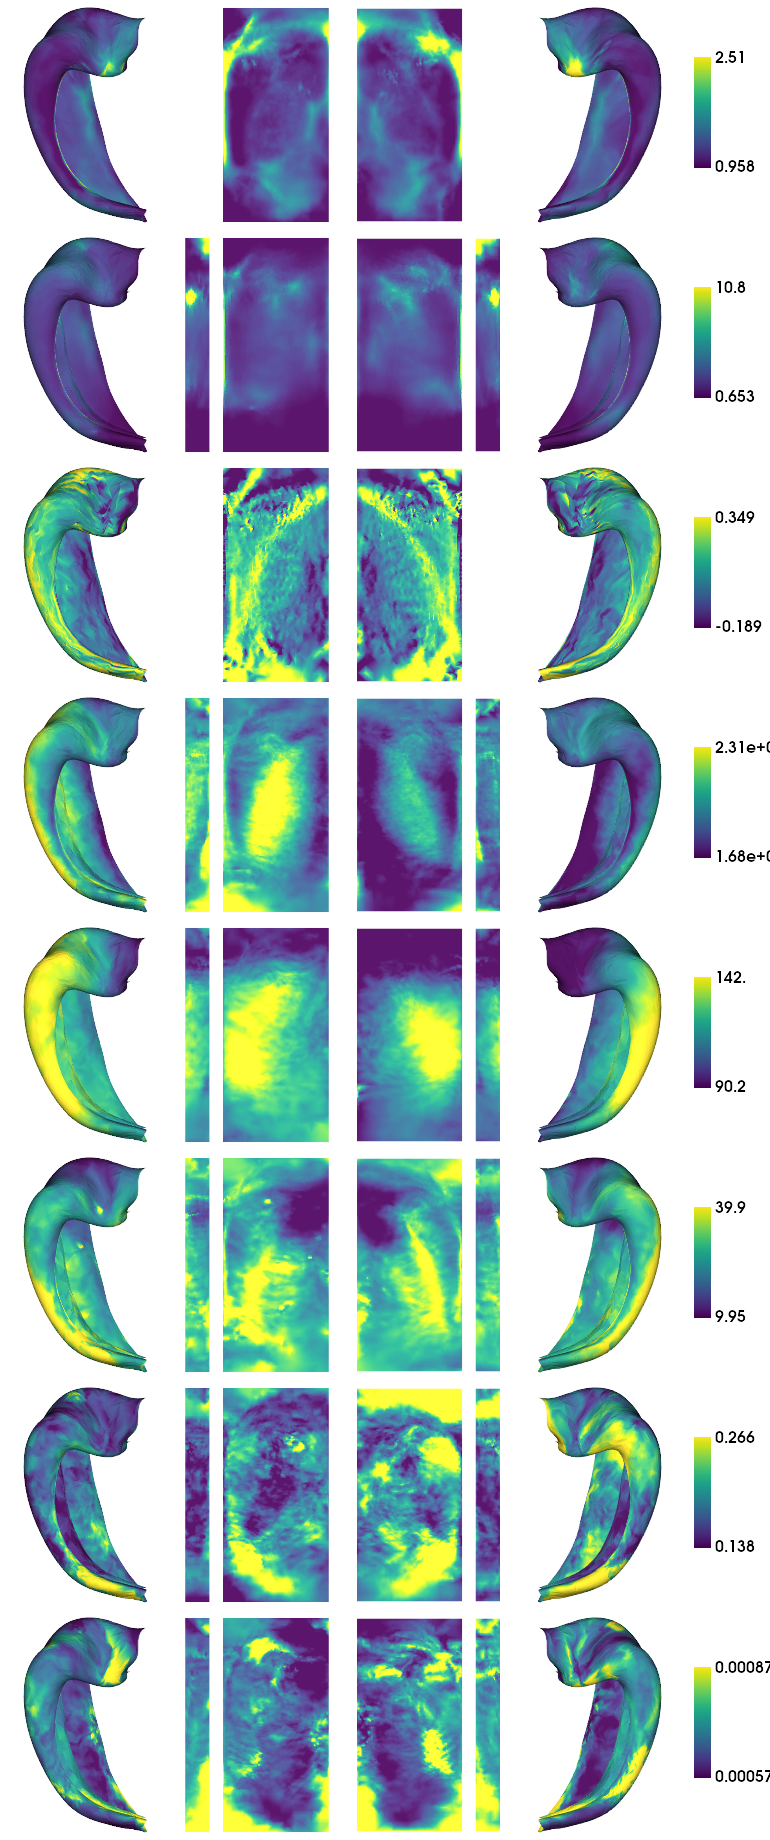

In [6]:
cdata = np.nanmean(hipp_dat,axis=2)
plotting.surfplot_canonical_foldunfold(cdata[:,:,:], color_bar=('right'), share='row', tighten_cwindow=True, embed_nb=True)

In [7]:
hipp_dat.shape

(9050, 2, 7, 8)

/tmp/ipykernel_9080/2093364549.py:1: RuntimeWarning: Mean of empty slice
  cdata = np.nanmean(hipp_dat,axis=(1,2))


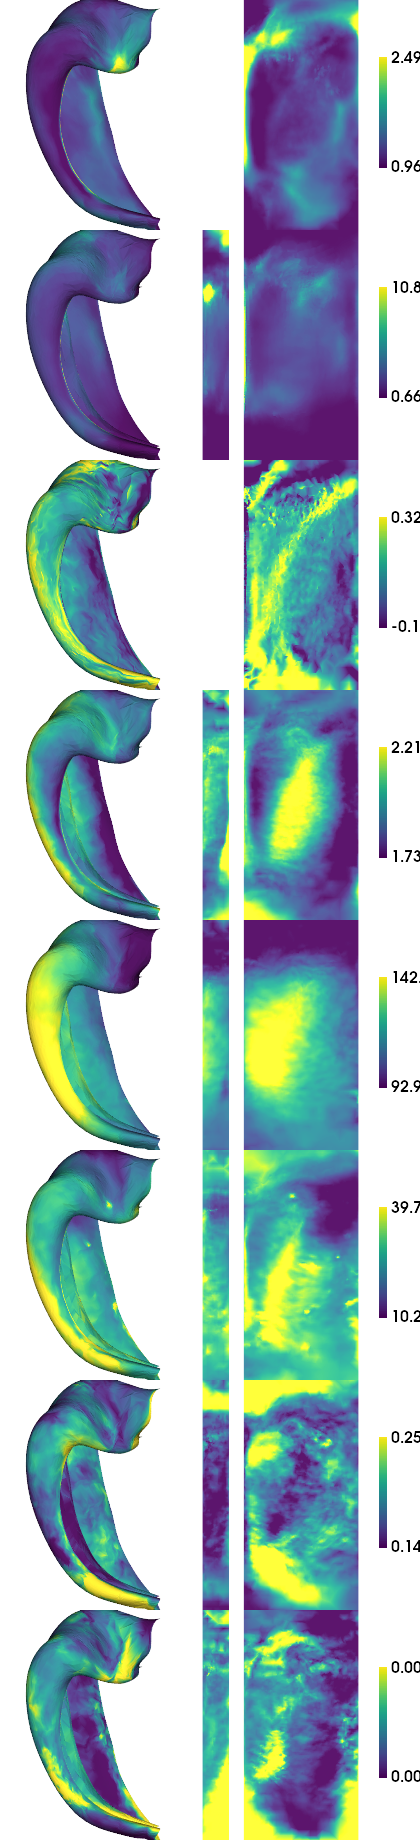

In [8]:
cdata = np.nanmean(hipp_dat,axis=(1,2))
plotting.surfplot_canonical_foldunfold(cdata, color_bar=('right'), hemis=['L'], share='row', tighten_cwindow=True, embed_nb=True)

In [9]:
for i in range(8):
    plotting.surfplot_canonical_foldunfold(cdata[:,i], color_bar=('right'), hemis=['L'], size=[350,270], share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename=f'{i}.png')

## Add histology data
Since the histology has only one hemisphere and no DG, we will heep only this data from MRI

In [10]:
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [11]:
downsampled_histo = np.load("../checkpoints/struct-HISTO-proc-midsurfaces.npy")
struct_data = np.concatenate((downsampled_histo,np.nanmean(cdata[ind[0],:,:],axis=1)),axis=1)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# correlation between features
feat_corr = np.corrcoef(struct_data.T)
allfeatures = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'PD',\
               'qR1', 'qR2star', 'thickness', 'gyrification', 'curvature', 'T1map', 'MTR', 'T2star', 'FA', 'ADC']

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [ ]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(struct_data[:,:], sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], size=[350,270], color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

In [ ]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)

In [ ]:
mmgm.gradients_.shape